Conversão e teste dos modelos.

In [ ]:
!pip install ultralytics

In [ ]:
from ultralytics import YOLO
import argparse
import sys

if __name__ == '__main__':
    parser = argparse.ArgumentParser()
    parser.add_argument("--model", default="./best.pt", type=str)
    parser.add_argument("--format", default="tflite", type=str)

    # Filter out unknown arguments
    args, unknown = parser.parse_known_args()

    # Load a model
    model = YOLO(args.model)

    if args.format == 'tflite':
        model.export(format='tflite', int8=True, data='path_to_your_data.yaml')
    elif args.format == 'onnx':
        model.export(format='onnx')
    else:
        raise Exception(f'unknown format: {args.format}')

In [ ]:
import shutil
from google.colab import files

# Caminho da pasta que você deseja baixar
folder_path = '/content/best_saved_model'

# Nome do arquivo zip que será criado
output_filename = 'best_saved_model.zip'

# Compacta a pasta
shutil.make_archive(output_filename.replace('.zip', ''), 'zip', folder_path)

# Faz o download do arquivo zip
files.download(output_filename)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

TFLite

Raw TFLite model output:
[[[   0.023979    0.072323    0.094208 ...    -0.12499  6.3658e-05     0.14956]
  [   0.016309    0.011938    0.015811 ...      0.8128      0.8137     0.83267]
  [   0.051562     0.14897     0.21222 ...       1.625      1.6251      1.5775]
  [   0.031551    0.022243    0.030839 ...     0.25059     0.25239     0.22981]
  [  0.0058011  0.00031715  2.0014e-05 ...  3.3294e-07  1.9103e-06  4.9492e-05]]]
Number of bounding boxes detected after NMS: 4


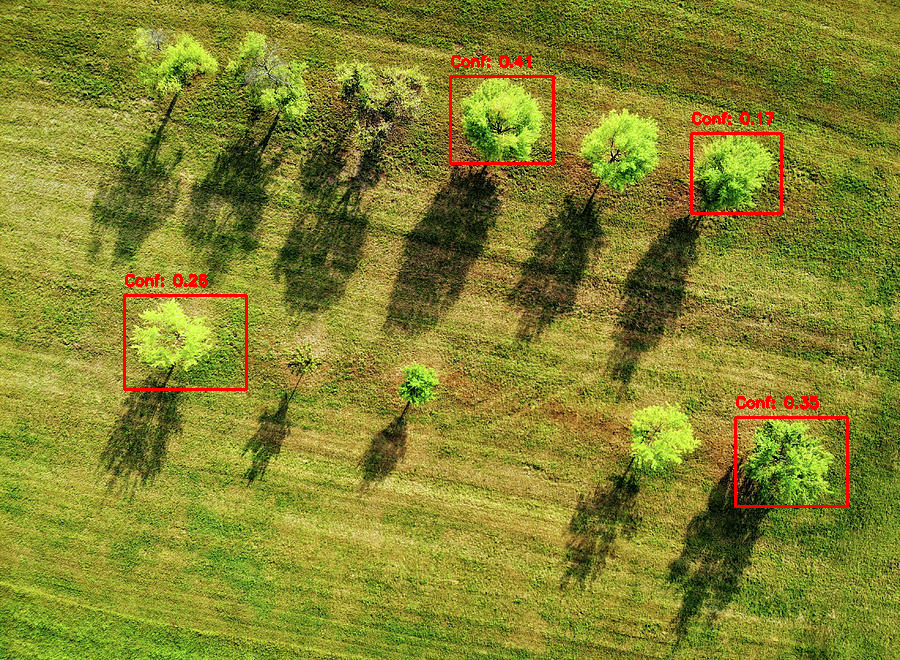

In [ ]:
import cv2
import numpy as np
import tensorflow as tf
from google.colab.patches import cv2_imshow

def preprocess_image_for_tflite(image, input_size):
    image_resized = cv2.resize(image, (input_size, input_size))
    image_normalized = image_resized / 255.0
    return np.expand_dims(image_normalized, axis=0).astype(np.float32)

def run_tflite_model(tflite_model_path, image):
    interpreter = tf.lite.Interpreter(model_path=tflite_model_path)
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()

    # Executa a predição
    interpreter.set_tensor(input_details[0]['index'], image)
    interpreter.invoke()

    # Obtém a saída do modelo
    output_data = interpreter.get_tensor(output_details[0]['index'])
    return output_data

def extract_boxes_and_scores_tflite(output, conf_threshold=0.1):  # Threshold reduzido
    output = np.squeeze(output)  # Remove dimensões unitárias
    boxes = []
    scores = []

    for i in range(output.shape[1]):
        x_center, y_center, width, height, confidence = output[:, i]

        if confidence > conf_threshold:
            xmin = x_center - (width / 2)
            ymin = y_center - (height / 2)
            xmax = x_center + (width / 2)
            ymax = y_center + (height / 2)

            boxes.append([xmin, ymin, xmax, ymax])
            scores.append(confidence)

    return np.array(boxes), np.array(scores)

def non_max_suppression(boxes, scores, iou_threshold=0.15):
    indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), score_threshold=0.0, nms_threshold=iou_threshold)
    if len(indices) > 0:
        indices = indices.flatten()
    else:
        indices = []
    return indices

def draw_boxes(image, boxes, scores, indices):
    h, w, _ = image.shape

    for i in indices:
        xmin, ymin, xmax, ymax = boxes[i]

        # Converte as coordenadas relativas para absolutas
        xmin = int(xmin * w)
        ymin = int(ymin * h)
        xmax = int(xmax * w)
        ymax = int(ymax * h)

        # Desenha o bounding box na imagem
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        label = f"Conf: {scores[i]:.2f}"
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image

# Caminho do modelo e da imagem
tflite_model_path = "./best_saved_model/best_int8.tflite"
image_path = "./Arvore.jpg"

# Carrega e preprocessa a imagem
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image at path {image_path} not found ou unable to load.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_size = 256
processed_image = preprocess_image_for_tflite(image_rgb, input_size)

# Executa o modelo TFLite
output = run_tflite_model(tflite_model_path, processed_image)

# Visualiza a saída bruta do modelo
print("Raw TFLite model output:")
print(output)

# Extrai bounding boxes e confidências com threshold reduzido
boxes, scores = extract_boxes_and_scores_tflite(output)

# Aplicar Non-Maximum Suppression (NMS)
indices = non_max_suppression(boxes, scores)

# Verifica e imprime quantas caixas foram detectadas após o NMS
num_boxes = len(indices)
print(f"Number of bounding boxes detected after NMS: {num_boxes}")

if num_boxes == 0:
    print("No bounding boxes detected after NMS. Please check the model output or confidence threshold.")

# Desenha as caixas delimitadoras na imagem original, se houver alguma
if num_boxes > 0:
    image_with_boxes = draw_boxes(image_rgb, boxes, scores, indices)

    # Converte de volta para BGR para exibir com OpenCV
    image_bgr = cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR)
    cv2_imshow(image_bgr)  # Exibe a imagem no Colab

ONNX

Number of bounding boxes detected after NMS: 5


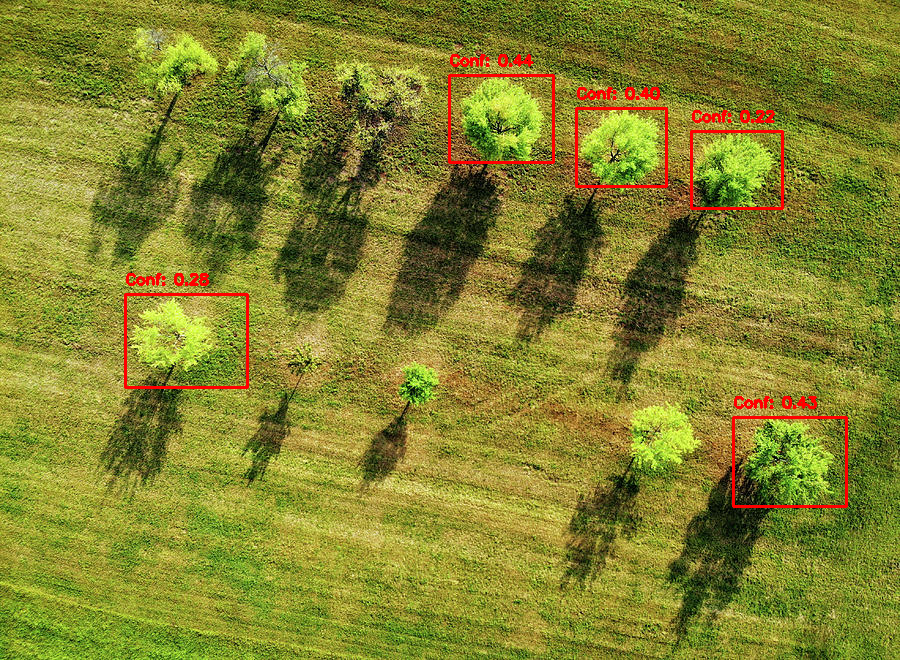

In [ ]:
import cv2
import numpy as np
import onnxruntime as ort
from google.colab.patches import cv2_imshow

def preprocess_image_for_onnx(image, input_size):
    image_resized = cv2.resize(image, (input_size, input_size))
    image_normalized = image_resized / 255.0
    image_transposed = np.transpose(image_normalized, (2, 0, 1))  # Para ONNX (C, H, W)
    return np.expand_dims(image_transposed, axis=0).astype(np.float32)

def run_onnx_model(onnx_model_path, image):
    ort_session = ort.InferenceSession(onnx_model_path)
    ort_inputs = {ort_session.get_inputs()[0].name: image}
    ort_outs = ort_session.run(None, ort_inputs)
    return ort_outs[0]  # Retorna a primeira saída

def extract_boxes_and_scores(output, conf_threshold=0.2):  # Threshold reduzido
    output = np.squeeze(output)  # Remove dimensões unitárias
    boxes = []
    scores = []

    for i in range(output.shape[1]):
        x_center, y_center, width, height, confidence = output[:, i]

        if confidence > conf_threshold:
            xmin = x_center - (width / 2)
            ymin = y_center - (height / 2)
            xmax = x_center + (width / 2)
            ymax = y_center + (height / 2)

            boxes.append([xmin, ymin, xmax, ymax])
            scores.append(confidence)

    return np.array(boxes), np.array(scores)

def non_max_suppression(boxes, scores, iou_threshold=0.5):
    indices = cv2.dnn.NMSBoxes(boxes.tolist(), scores.tolist(), score_threshold=0.0, nms_threshold=iou_threshold)
    if len(indices) > 0:
        indices = indices.flatten()
    else:
        indices = []
    return indices

def draw_boxes(image, boxes, scores, indices):
    h, w, _ = image.shape

    for i in indices:
        xmin, ymin, xmax, ymax = boxes[i]

        # Converte as coordenadas relativas para absolutas
        xmin = int(xmin * w)
        ymin = int(ymin * h)
        xmax = int(xmax * w)
        ymax = int(ymax * h)

        # Desenha o bounding box na imagem
        cv2.rectangle(image, (xmin, ymin), (xmax, ymax), (255, 0, 0), 2)
        label = f"Conf: {scores[i]:.2f}"
        cv2.putText(image, label, (xmin, ymin - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    return image

# Caminho do modelo e da imagem
onnx_model_path = "./best.onnx"
image_path = "./Arvore.jpg"

# Carrega e preprocessa a imagem
image = cv2.imread(image_path)
if image is None:
    raise FileNotFoundError(f"Image at path {image_path} not found ou unable to load.")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
input_size = 256
processed_image = preprocess_image_for_onnx(image_rgb, input_size)

# Executa o modelo ONNX
output = run_onnx_model(onnx_model_path, processed_image)

# Extrai bounding boxes e confidências com threshold reduzido
boxes, scores = extract_boxes_and_scores(output)

# Aplicar Non-Maximum Suppression (NMS)
indices = non_max_suppression(boxes, scores)

# Verifica e imprime quantas caixas foram detectadas após o NMS
num_boxes = len(indices)
print(f"Number of bounding boxes detected after NMS: {num_boxes}")

if num_boxes == 0:
    print("No bounding boxes detected after NMS. Please check the model output or confidence threshold.")

# Desenha as caixas delimitadoras na imagem original, se houver alguma
if num_boxes > 0:
    image_with_boxes = draw_boxes(image_rgb, boxes, scores, indices)

    # Converte de volta para BGR para exibir com OpenCV
    image_bgr = cv2.cvtColor(image_with_boxes, cv2.COLOR_RGB2BGR)
    cv2_imshow(image_bgr)  # Exibe a imagem no Colab